<a href="https://colab.research.google.com/github/hyooz-Kang/Hmm2Song/blob/subeen/3.%20modeling_pairwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. settings**

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
import pandas as pd
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

### GPU 사용 여부 체크
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")

Using cuda for training.


# **2. Preparing Data**
- 원곡 음원과 허밍 음원(변형된 음원)의 mel 벡터를 데이터프레임에 매칭
  - 각 음원 조각별로 5가지의 변형
- train_map 리스트에 각 원본 음원과 허밍 음원의 경로를 튜플로 저장

## **2-1. Load & Map Data**

In [ ]:
### 곡 번호 가져오기

input_path = '/content/drive/MyDrive/Hmm2Song/data/song/Split_input/'

files = os.listdir(input_path)
mp3_files = [f for f in files if f.endswith(".mp3")]
mp3_files = sorted(mp3_files)

# 곡 번호 추출
numbers = []
for f in mp3_files:
  # Split the filename by "/"
  parts = f.split("/")
  # Get the last part of the filename, which is the ID
  number = parts[-1].split("_")[0]
  numbers.append(number)

In [ ]:
### 데이터 파일 경로 설정

org_path = '/content/drive/MyDrive/Hmm2Song/data/song/org.npy'
fh_path = '/content/drive/MyDrive/Hmm2Song/data/song/fh.npy'
fl_path = '/content/drive/MyDrive/Hmm2Song/data/song/fl.npy'
mh_path = '/content/drive/MyDrive/Hmm2Song/data/song/mh.npy'
ml_path = '/content/drive/MyDrive/Hmm2Song/data/song/ml.npy'
n_path = '/content/drive/MyDrive/Hmm2Song/data/song/n.npy'

In [ ]:
### 원곡 & 허밍 데이터 로드
org = np.load(org_path, allow_pickle = True)
fh = np.load(fh_path, allow_pickle = True)
fl = np.load(fl_path, allow_pickle = True)
mh = np.load(mh_path, allow_pickle = True)
ml = np.load(ml_path, allow_pickle = True)
n = np.load(n_path, allow_pickle = True)

In [ ]:
### 데이터프레임 생성
data = {
    'song_no': numbers,
    'org': org,
    'fh': fh,
    'fl': fl,
    'mh': mh,
    'ml': ml,
    'n': n
}

music = pd.DataFrame(data)
music.head()

,song_no,org,fh,fl,mh,ml,n
0,000,"[[-53.434498, -53.434498, -53.434498, -53.4344...","[[-64.46365, -64.46365, -64.46365, -64.46365, ...","[[-53.462494, -53.462494, -53.462494, -53.4624...","[[-55.8885, -55.8885, -55.8885, -55.8885, -55....","[[-55.95763, -55.95763, -55.95763, -55.95763, ...","[[-9.18961, -8.082821, -10.054024, -9.653147, ..."
1,000,"[[-11.306869, -10.583914, -13.366933, -14.5223...","[[-33.90235, -39.70997, -57.306282, -57.306282...","[[-11.283159, -10.587484, -13.5872135, -14.666...","[[-12.906219, -11.651057, -14.351291, -15.2013...","[[-10.752398, -10.82634, -14.578722, -15.97892...","[[-5.086788, -5.206139, -11.650671, -7.4844594..."
2,000,"[[-7.9065266, -10.674957, -13.891659, -20.9580...","[[-44.07569, -49.08165, -47.601494, -48.4676, ...","[[-8.294864, -10.802288, -13.778696, -21.03367...","[[-9.173194, -13.967354, -21.154625, -29.20704...","[[-6.0015, -9.459395, -13.348994, -20.772518, ...","[[-4.316294, -7.043939, -8.572198, -9.052606, ..."
3,000,"[[20.618156, 21.427076, 19.18558, 13.680927, 3...","[[-30.319366, -31.61372, -34.726913, -40.04141...","[[20.610598, 21.41199, 19.180431, 13.631516, 3...","[[16.674326, 14.218125, 11.978937, 7.5957184, ...","[[23.048532, 24.449047, 21.363308, 15.357315, ...","[[20.633581, 21.456093, 19.215803, 13.742048, ..."
4,000,"[[-16.27028, -21.62627, -47.989334, -50.855732...","[[-45.3732, -53.73243, -59.59111, -59.59111, -...","[[-14.381916, -19.772512, -47.65141, -51.05184...","[[-19.572826, -24.678566, -46.37851, -52.57517...","[[-15.229172, -20.558203, -43.36681, -43.05114...","[[-6.430007, -8.372921, -9.389027, -9.194475, ..."


각각의 곡에 대해 원곡과 허밍된 음성의 mel 값이 벡터 형태로 넘어온다.


In [ ]:
len(music)

22730

## **2-2. Train/Test Split**
- train의 경우 각 원본 음원과 허밍 음원의 mel 벡터를 쌍으로 매칭해 튜플로 저장
- test의 경우 mel 벡터만 저장

In [ ]:
def make_train_test(df, random_seed = 42):

    np.random.seed(random_seed)

    train_maps, test_li = [], []

    for index, row in df.iterrows():
        test_hum_col = np.random.choice(['fh', 'fl', 'mh', 'ml', 'n'])
        test = row[test_hum_col]
        test_li.append(test)

        train_hum_cols = list(set(['fh', 'fl', 'mh', 'ml', 'n']) - {test_hum_col})
        for train_hum_col in train_hum_cols:
            train_map = (row['org'], row[train_hum_col])
            train_maps.append(train_map)

    return train_maps, test_li

In [ ]:
train_map, test = make_train_test(music, random_seed = 42)

In [ ]:
train_map[0]

(array([[-53.434498 , -53.434498 , -53.434498 , ..., -11.491163 ,
         -19.790825 ,  -4.282523 ],
        [-53.434498 , -53.434498 , -53.434498 , ...,  -6.7589192,
         -10.0783825,  -3.128749 ],
        [-53.434498 , -53.434498 , -53.434498 , ...,  -6.1969037,
          -9.043031 ,   1.9364727],
        ...,
        [-53.434498 , -53.434498 , -53.434498 , ..., -53.434498 ,
         -53.434498 , -33.53729  ],
        [-53.434498 , -53.434498 , -53.434498 , ..., -53.434498 ,
         -53.434498 , -33.758835 ],
        [-53.434498 , -53.434498 , -53.434498 , ..., -53.434498 ,
         -53.434498 , -35.193287 ]], dtype=float32),
 array([[-64.46365 , -64.46365 , -64.46365 , ..., -60.716553, -50.279163,
         -29.761612],
        [-64.46365 , -64.46365 , -64.46365 , ..., -48.66716 , -49.227592,
         -30.205107],
        [-64.46365 , -64.46365 , -64.46365 , ..., -46.834373, -48.482704,
         -32.23804 ],
        ...,
        [-64.46365 , -64.46365 , -64.46365 , ..., -64.463

In [ ]:
train_map[0][0].shape

(128, 431)

In [ ]:
test[0]

array([[-55.95763  , -55.95763  , -55.95763  , ..., -13.875435 ,
        -15.662851 ,  -5.4593253],
       [-55.95763  , -55.95763  , -55.95763  , ...,  -7.1582246,
        -11.020405 ,  -2.7339075],
       [-55.95763  , -55.95763  , -55.95763  , ...,   6.5668344,
          6.6708145,   6.1347055],
       ...,
       [-55.95763  , -55.95763  , -55.95763  , ..., -55.95763  ,
        -52.45276  , -37.819366 ],
       [-55.95763  , -55.95763  , -55.95763  , ..., -55.95763  ,
        -53.005585 , -37.424305 ],
       [-55.95763  , -55.95763  , -55.95763  , ..., -55.95763  ,
        -55.95763  , -40.89798  ]], dtype=float32)

In [ ]:
test[0].shape

(128, 431)

# **3. Dataset**
- 데이터셋을 정의하고 로드하는 과정
- Triplet Loss를 계산하기 위한 triplet dataset 생성
- PyTorch의 `Dataset` 클래스를 상속받아 트리플렛 데이터셋을 구현
- 원본 음원, 변형된 음원, 부정적 예제로 이루어진 트리플렛 쌍을 제공
  - 각 샘플은 anchor(허밍), positive(원곡), negative(다른곡)의 세 부분으로 구성됨

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F

In [ ]:
### 스펙트로그램 불러오기
## 128: 주파수, 431: 시간 스텝 수

def load_spectrogram(spectrogram):
  if not isinstance(spectrogram, torch.Tensor):
    spectrogram = torch.tensor(spectrogram)
  if spectrogram.shape != (128, 431): # 길이가 짧게 잘린 음원에 패딩을 0으로 넣어 모양을 맞춰줌
    pad = (0, 431 - spectrogram.shape[1])
    spectrogram = F.pad(spectrogram, pad, "constant", 0)

  return spectrogram

In [ ]:
class MusicTripletDataset(Dataset):

  ### 클래스를 초기화하고 데이터셋의 정보를 설정
  def __init__(self, music_files):
    self.music_files = music_files # (원곡, 허밍)

  ### 데이터셋의 전체 길이를 반환
  def __len__(self):
    return len(self.music_files)

  ### 트리플렛 데이터셋 구성
  def __getitem__(self, idx):
    ## 원곡(Positive)과 허밍(Anchor) 데이터 쌍 구성
    positive_file, anchor_file = self.music_files[idx]
    # 스펙트로그램 정보 가져오기
    positive = load_spectrogram(positive_file)
    anchor = load_spectrogram(anchor_file)

    ## 부정(negative) 예제 생성
    # positive가 아닌 것은 모두 부정 예제 -> 임의의 곡을 선택하여 부정 예제로 학습시킴
    negative_idx = np.random.choice([i for i in range(len(self.music_files)) if i != idx])
    negative_file = self.music_files[negative_idx][0] # 다른 곡(-> 원곡) 선택
    negative = load_spectrogram(negative_file)

    return anchor, positive, negative

In [ ]:
### 데이터 준비
train = MusicTripletDataset(train_map)
test = [load_spectrogram(spec) for spec in test]

# 미니배치 단위로 데이터를 효율적으로 불러오기
batch_size = 64
trainloader = DataLoader(train, batch_size = batch_size, shuffle = True)

In [ ]:
### 데이터 shape 확인
anchor, positive, negative = next(iter(trainloader))

print('Anchor shape:', anchor.shape)
print('Positive shape:', positive.shape)
print('Negative shape:', negative.shape)

Anchor shape: torch.Size([64, 128, 431])
Positive shape: torch.Size([64, 128, 431])
Negative shape: torch.Size([64, 128, 431])


batch_size, height(= 주파수), width(= time step)

# **4. Modeling**
- 신경망 모델을 정의하고 훈련하는 부분
  - Triplet Loss를 활용한 학습을 위한 모델 구성 부분
- Triplet Loss는 세 가지 샘플(Anchor, Positive, Negative) 간의 거리 관계를 학습
  - Anchor(허밍)와 Positive(원곡) 간의 거리를 최소화하고, Anchor(허밍)와 Negative(다른곡) 간의 거리를 최대화하는 방식으로 모델을 훈련

In [ ]:
import torch.nn as nn

In [ ]:
### 학습을 위한 모델 구성 부분
## 음원 스펙트로그램에 적합한 합성곱 층과 풀링 층, 그리고 완전 연결 층으로 구성

class ConvSubnet(nn.Module):
  def __init__(self, embedding_dims = 128):
    super(ConvSubnet, self).__init__()
    ## Convolutional Layer
    self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
    ## MaxPooling Layer
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    ## Fully Connected Layer
    # maxpooling을 3번 거치면서 height(128 => 64 -> 32 -> 16), width(431 => 215, 107, 53)
    self.fc = nn.Linear(848, embedding_dims)  # 16 * 53 = 848

  def forward(self, x):
    ## 데이터 차원 조정 -> [batch, channel, height, width]
    x = x.unsqueeze(1)
    ## Convolutional Layer를 통과시켜 특징을 추출하고 활성화 함수를 적용
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    ## 데이터를 1차원으로 펼침
    x = x.view(-1, 848)
    ## FC Layer를 통과시켜 임베딩 생성
    x = self.fc(x)
    return x

In [ ]:
import matplotlib.pyplot as plt

### Loss 시각화 함수
def plot_loss_curve(loss_curve):
  plt.plot(loss_curve, label='Training Loss')
  plt.title('Training Loss Curve')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
### TripletMarginLoss 및 모델 초기화

margin = 1.0 # positive와 negative 사이의 최소 거리
triplet_loss = nn.TripletMarginLoss(margin = margin, p = 2) # Pytorch 내장함수 활용
model = ConvSubnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
## 모델 가중치 저장
now = datetime.now().strftime('%Y%m%d_%H%M%S')
model_dir = f'/content/drive/MyDrive/Hmm2Song/차수빈/model/{now}/'
os.mkdir(model_dir)

In [ ]:
### 학습 loop 최적화

num_epochs = 5
checkpoint = 1
log_steps = 50
loss_curve = []  # Loss 저장을 위한 리스트

# 모델을 학습 모드로 설정
model.train()

for epoch in range(num_epochs):
  print(f'========== Epoch {epoch + 1} ==========')
  for step, (anchor, positive, negative) in enumerate(trainloader, 1):
    optimizer.zero_grad()

    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
    embedded_anchor, embedded_positive, embedded_negative = model(anchor), model(positive), model(negative)

    loss = triplet_loss(embedded_anchor, embedded_positive, embedded_negative)
    loss.backward()
    optimizer.step()

    loss_curve.append(loss.item())

    if step % log_steps == 0:
      print(f'Epoch {epoch + 1}, Step {step}, Loss: {loss.item()}')

  # 에폭이 끝날 때마다 모델 저장
  if (epoch + 1) % checkpoint == 0:
      torch.save(model.state_dict(), os.path.join(model_dir, f'model_weights_{epoch + 1}.pth'))

  print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
  print()

========== Epoch 1 ==========
Epoch 1, Step 50, Loss: 0.0001452234573662281
Epoch 1, Step 100, Loss: 1.0759365977719426e-05
Epoch 1, Step 150, Loss: 0.03597059100866318
Epoch 1, Step 200, Loss: 0.0
Epoch 1, Step 250, Loss: 0.0
Epoch 1, Step 300, Loss: 0.0002625648630782962
Epoch 1, Step 350, Loss: 8.838018402457237e-05
Epoch 1, Step 400, Loss: 0.0
Epoch 1, Step 450, Loss: 0.0
Epoch 1, Step 500, Loss: 0.0
Epoch 1, Step 550, Loss: 0.0
Epoch 1, Step 600, Loss: 0.0
Epoch 1, Step 650, Loss: 0.0
Epoch 1, Step 700, Loss: 0.0
Epoch 1, Step 750, Loss: 5.384150426834822e-05
Epoch 1, Step 800, Loss: 0.0
Epoch 1, Step 850, Loss: 0.0
Epoch 1, Step 900, Loss: 0.12284291535615921
Epoch 1, Step 950, Loss: 0.004975906107574701
Epoch 1, Step 1000, Loss: 0.0009377403184771538
Epoch 1, Step 1050, Loss: 0.0
Epoch 1, Step 1100, Loss: 0.0059827035292983055
Epoch 1, Step 1150, Loss: 0.0008819949580356479
Epoch 1, Step 1200, Loss: 0.0
Epoch 1, Step 1250, Loss: 0.00013867666712030768
Epoch 1, Step 1300, Loss: 0

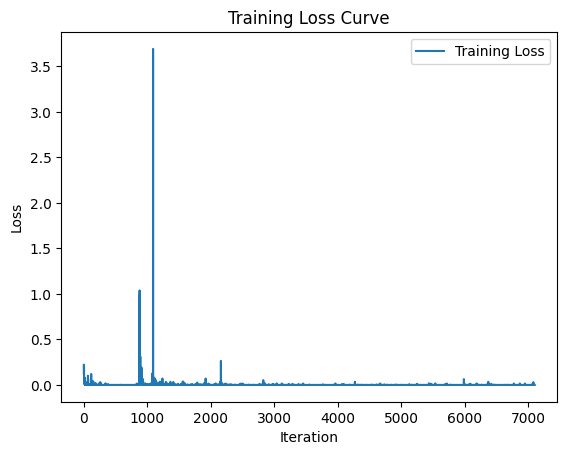

In [ ]:
### loss 시각화

plot_loss_curve(loss_curve)

# **5. Inference**
- 정확도는 모르겠고 추론이란 걸 한 번 해보아요 (oﾟvﾟ)ノ

In [ ]:
# 모델 로딩

model_path = '/content/drive/MyDrive/Hmm2Song/차수빈/model/euron_modeling_4.pth'
model = ConvSubnet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

ConvSubnet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=848, out_features=128, bias=True)
)

In [ ]:
# info.csv 로딩
song_info = pd.read_csv('/content/drive/MyDrive/Hmm2Song/data/info2.csv')
song_info.head()

,id,Title,Singer,Lyric,genre,path,gender
0,0,To. X,태연 (TAEYEON),처음 본 널 기억해 We skipped the small talk 바로 다음 단계였...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
1,1,Either Way,IVE (아이브),누가 내 말투가 재수없대 잘난 척만 한대 또 누구는 내가 너무 착하대 바보같을 정도...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
2,2,DIE 4 YOU,DEAN,I don’t wanna go Till everything comes crashin...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성
3,3,Must Have Love,"SG 워너비, 브라운아이드걸스",함께 있단 이유로 행복했었던 우리들의 겨울날의 소중한 기억들 좋은 날엔 언제나 네가...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,혼성
4,4,Still With You,정국,날 스치는 그대의 옅은 그 목소리 내 이름을 한 번만 더 불러주세요 얼어버린 노을 ...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성


In [ ]:
### 데이터형 변경

# id 컬럼을 object 형으로 변경
song_info['id'] = song_info['id'].astype('object')

# id 컬럼을 3자리로 맞춤
song_info['id'] = song_info['id'].apply(lambda x: str(x).zfill(3))

In [ ]:
song_info.head()

,id,Title,Singer,Lyric,genre,path,gender
0,000,To. X,태연 (TAEYEON),처음 본 널 기억해 We skipped the small talk 바로 다음 단계였...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
1,001,Either Way,IVE (아이브),누가 내 말투가 재수없대 잘난 척만 한대 또 누구는 내가 너무 착하대 바보같을 정도...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
2,002,DIE 4 YOU,DEAN,I don’t wanna go Till everything comes crashin...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성
3,003,Must Have Love,"SG 워너비, 브라운아이드걸스",함께 있단 이유로 행복했었던 우리들의 겨울날의 소중한 기억들 좋은 날엔 언제나 네가...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,혼성
4,004,Still With You,정국,날 스치는 그대의 옅은 그 목소리 내 이름을 한 번만 더 불러주세요 얼어버린 노을 ...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성


In [ ]:
### 원곡 음원 임베딩

music_emb = music[['song_no', 'org']]
music_emb['org_emb'] = music_emb['org'].apply(lambda x: load_spectrogram(x))
music_emb.head()

,song_no,org,org_emb
0,000,"[[-53.434498, -53.434498, -53.434498, -53.4344...","[[tensor(-53.4345), tensor(-53.4345), tensor(-..."
1,000,"[[-11.306869, -10.583914, -13.366933, -14.5223...","[[tensor(-11.3069), tensor(-10.5839), tensor(-..."
2,000,"[[-7.9065266, -10.674957, -13.891659, -20.9580...","[[tensor(-7.9065), tensor(-10.6750), tensor(-1..."
3,000,"[[20.618156, 21.427076, 19.18558, 13.680927, 3...","[[tensor(20.6182), tensor(21.4271), tensor(19...."
4,000,"[[-16.27028, -21.62627, -47.989334, -50.855732...","[[tensor(-16.2703), tensor(-21.6263), tensor(-..."


In [ ]:
### 추론

def infer_with_filtering(model, test_mel, music_df, info_df, user_genre, user_gender):
    with torch.no_grad():
        # 테스트 데이터에 대한 mel 벡터를 모델에 전달하여 임베딩 얻기
        test_embedding = model(test_mel.unsqueeze(0).to(device))

        # 필터링을 위한 데이터프레임 생성
        filtered_info_df = info_df[(info_df['genre'] == user_genre) & (info_df['gender'] == user_gender)]

        if filtered_info_df.empty:  # 필터링된 데이터가 없을 경우
            return None

        # 필터링된 데이터프레임의 id와 song_no를 일치시켜서 필터링된 음악 정보를 가져옴
        filtered_music_df = music_df[music_df['song_no'].isin(filtered_info_df['id'])].reset_index(drop=True)

        # 모든 원곡의 mel 벡터에 대해 임베딩을 계산하고 거리 측정
        distances = []
        for _, row in filtered_music_df.iterrows():
            org_embedding = model(row['org_emb'].unsqueeze(0).to(device))
            pdist = torch.nn.PairwiseDistance(p = 2)
            dist = pdist(test_embedding, org_embedding).cpu().numpy()
            distances.append(dist)

        if not distances:  # 필터링된 데이터가 없을 경우
            return None

        # 거리가 가장 가까운 원곡의 정보 얻기
        closest_idx = min(range(len(distances)), key = lambda i: distances[i][0])
        closest_song_no = filtered_music_df.loc[closest_idx, 'song_no']

        # 해당 원곡의 정보 얻기
        song_info = info_df.loc[info_df['id'] == closest_song_no].iloc[0]

    return song_info

**test 데이터로 검증**

In [ ]:
print(numbers[50])

002


In [ ]:
test_mel = test[50] # 002

user_genre = input("장르를 입력하세요: ")
user_gender = input("성별을 입력하세요: ")

장르를 입력하세요: RnB_Soul
성별을 입력하세요: 남성


In [ ]:
## 추론 결과 얻기
inferred_info = infer_with_filtering(model, test_mel, music_emb, song_info, user_genre, user_gender)

if inferred_info.any():
    print("== 가장 유사한 원곡 정보 ==")
    print("곡 번호:", inferred_info['id'])
    print("제목:", inferred_info['Title'])
    print("가수:", inferred_info['Singer'])
    print("장르:", inferred_info['genre'])
    print("가수 성별:", inferred_info['gender'])
    print("가사:", inferred_info['Lyric'])
else:
    print("입력한 장르와 성별에 해당하는 음악이 없습니다.")

== 가장 유사한 원곡 정보 ==
곡 번호: 002
제목: DIE 4 YOU
가수: DEAN
장르: RnB_Soul
가수 성별: 남성
가사: I don’t wanna go Till everything comes crashing down (나는 어디에도 가지 않을거야 모든 것이 무너지기전까진)  You’re the one I want When everything comes crashing down (모든것이 무너질때, 넌 내가 원하는 유일한 사람이야)  그냥 왜인지 난 너가 돌아올 것 같은데  I don’t wanna go Till everything comes crashing down (나는 어디에도 가지 않을거야 모든 것이 무너지기전까진)  You’re the one I want When everything comes crashing down (모든것이 무너질때, 넌 내가 원하는 유일한 사람이야)  Could you tell me once again, again? (한번만 더 말해 줄 수 있어?)  Oh-oh-oh  널 안아줬던 그 날 처럼 오늘도 비가 오고 있어  Could you kill me once again, again? (한번만 더 날 죽여줄 수 있어?)  Oh-oh-oh  Cuz I know, I know I’ll be loving you I’ll be loving you (왜냐면 난 알거든 내가 널 계속 사랑할거라는걸)  I’m still loving you (난 아직 널 사랑해)  Baby you know I’d die for you (알잖아 난 널 위해서라면 죽을수도 있어)  네가 떠오르면 나는 미쳐 사실 아직 안믿겨 늦었을지도 모르지만 Let you know  어떤 멜로디도 그 어떤 스토리도 내겐 네 잔상일 뿐인데  I know it is way too late (너무 늦은걸 알지만)  I know it is way too crazy (너무 미친소리인걸 알지만)  But if you give me one more chance (하지만 너가

In [ ]:
# Test Accuracy
correct = 0  # 맞는 곡의 개수

for i in range(1000):
    test_mel = test[i]
    answer_id = numbers[i]

    user_genre = song_info.loc[song_info['id'] == answer_id, 'genre'].values[0]
    user_gender = song_info.loc[song_info['id'] == answer_id, 'gender'].values[0]

    inferred_info = infer_with_filtering(model, test_mel, music_emb, song_info, user_genre, user_gender)

    if inferred_info.any():
      inferred_id = inferred_info['id']

      if inferred_id == answer_id:
        correct += 1

accuracy = (correct / 1000) * 100
print(f"정확도: {round(accuracy, 2)}%")

정확도: 99.5%


**직접 허밍한 음성으로 테스트**

In [ ]:
def test_spectrogram(test_path):
  y, sr = librosa.load(test_path)
  test_melspec = librosa.feature.melspectrogram(y=y, sr=sr)
  log_test_melspec = librosa.power_to_db(test_melspec) # 학습 데이터 생성 시 해당 부분이 추가되어 있었음!

  test_res = load_spectrogram(log_test_melspec)

  return test_res

In [ ]:
test_hum = '/content/drive/MyDrive/Hmm2Song/차수빈/test_voice/sung.mp3' # 016
test_mel = test_spectrogram(test_hum)

user_genre = input("장르를 입력하세요: ")
user_gender = input("성별을 입력하세요: ")

장르를 입력하세요: RnB_Soul
성별을 입력하세요: 여성


In [ ]:
## 추론 결과 얻기
inferred_info = infer_with_filtering(model, test_mel, music_emb, song_info, user_genre, user_gender)

if inferred_info.any():
    print("== 가장 유사한 원곡 정보 ==")
    print("곡 번호:", inferred_info['id'])
    print("제목:", inferred_info['Title'])
    print("가수:", inferred_info['Singer'])
    print("장르:", inferred_info['genre'])
    print("가수 성별:", inferred_info['gender'])
    print("가사:", inferred_info['Lyric'])
else:
    print("입력한 장르와 성별에 해당하는 음악이 없습니다.")

== 가장 유사한 원곡 정보 ==
곡 번호: 084
제목: 0310
가수: 백예린 (Yerin Baek)
장르: RnB_Soul
가수 성별: 여성
가사: You smoked and you looked at me 넌 담배를 피며 날 쳐다봤어 I hate it when you do 난 네가 그럴 때가 싫더라 I said “no thanks” to you 난 됐다고 말했고 you asked me If I was okay, 넌 괜찮냐 물었지 what If I wasn’t 안 괜찮다면 뭐 어때  Leaving is fine 떠나도 괜찮아 It’s just I don’t wanna be all by myself again 난 그냥 또 다시 혼자가 되고 싶지 않은데 like every time, like every last time 항상 그랬듯, 항상 그전처럼 말야  You knew that I was no good for you 넌 내가 너에게 좋지 않을 거란 걸 알았어 when we lay down after doing that things you loved 네가 좋아하던 것들을 하고나서 누워있을 때 말야 you knew that I wasn’t better than you 넌 내가 너보다 나은 사람이 아닌 걸 알고 있었어 I hope that I could be seemed really fine with you leaving 네가 떠나도 괜찮아 보일 수 있으면 좋겠어   You stroked me and stared at me 넌 날 쓰다듬고 빤히 보곤 했지 I like it when you do 네가 그럴 때 참 좋았는데 I said “I know you love me too” 난 너도 나 사랑하는 거 안다고 말했고 I asked you, 난 물었어 “If you are the same, what If I quit it” 넌 똑같은데, 내가 그만두면 어쩔 거냐고  Leaving is fine 떠나는 건 괜찮아 It’s just I don’t wanna be fall